In [6]:
import os
import random
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import numpy as np
import spacy
import string
from wordcloud import WordCloud
import unicodedata

# Using spacy.load() to load the Filipino FastText model
nlp = spacy.load("tl_fasttext_transition")  # Load the Filipino FastText model

# Folder paths
transcripts_folder_path = 'cleaned_transcripts/'
tags_folder_path = 'tags/'

# Function to load random documents
def load_random_documents(folder_path, sample_size=100):
    all_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.txt')]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    documents = []
    file_names = []
    for file_name in sampled_files:
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            content = file.read().lower()
            if len(content.split()) >= 100:
                documents.append(content)
                file_names.append(file_name)
    return documents, file_names

documents, file_names = load_random_documents(transcripts_folder_path)

# Function to load video tags
def load_video_tags(folder_path):
    video_tags = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            video_id = file_name.split('_')[0]
            with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()
    return video_tags

video_tags = load_video_tags(tags_folder_path)

# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                     'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                     'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow' ]
broad_terms = ['philippines', 'philippine', 'british', 'filipino', 'video', 'http', 'korea', 'korean', 
               'youtube', 'google', 'united', 'america', 'american']
kpop_keywords = ['kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 'seventeen', 
                 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
more_keywords = [
    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 
    'journalist', 'headline', 'reporter', 'current events', 'special report', 
    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy', 'alright', 'ta', 'day', 'ooh', 'en', 'do', 'lot', 'comment', 'notification', 
    'korean', 'jjajangmyeon', 'jajangmyeon', 'damn', 'yall', 'month', 'week', 'year', 'ohhh', 'pvf', 'dude', 'mmm', 'kagilagilalas', 'ofcourse', 'australia', 'uxo', 
    'atleast', 'yusuf', 'bangkok', 'ot', 'anytime', 'allover', 'kala', 'nope', 'wan', 'brazil', 'smooth', 'ot', 'timeshere', 'batchof', 'yep', 'opo', 'del',
    'gosh', 'po', 'ourself', 'wo', 'wait', 'ugh', 'nyc', 'whoa', 'nicaragua', 'yup', 'em', 'bout', 'le', 'omg', 'overwhelm', 'maam', 'nicer', 'haha', 'hahaha', 'ha', 
    'nbcs', 'lana', 'rc', 'whatsoever', 'oxy', 'decade', 'whyd', 'unknown', 'ahhhhh', 'ohoh', 'ohto', 'ohhhh', 'bruh', 'ooe', 'ahmedabad', 'mexico', 
    'understand', 'excuse', 'kinda', 'applause', 'oooh', 'thiswhat', 'nevermind', 'ahh', 'againthank', 'toto', 'aww', 'nah', 'bbmas', 'ay', 'op', 'huh', 'huhu',
    'tada', 'beacuse', 'voila', 'upstairs', 'thatswhy', 'yea', 'that', 'armenia', 'or', 'not', 'funwhat', 'aka', 'armeniathat', 'woosexy', 'worth', 'laugh', 'box', 
    'xd', 'vb', 'eff', 'ananya', 'welsh', 'latron', 'shout', 'whatwhat', 'what', 'pause', 'why', 'thats', 'byebye', 'iv', 'bye'  
]
stop_words.update(custom_stop_words, kpop_keywords, broad_terms, more_keywords, github_stopwords)

lemmatizer = WordNetLemmatizer()

# Identify Filipino words using SpaCy model
def is_filipino_word(word):
    # Process the word using SpaCy
    doc = nlp(word)
    # Use the word vector from SpaCy to determine if it's a Filipino word
    embedding = doc.vector
    return np.linalg.norm(embedding) > 0.75  # This threshold might need adjustment

# Helper function to check if a word contains only Latin script characters
def is_latin_script(word):
    for char in word:
        if not ('LATIN' in unicodedata.name(char, '') or char.isdigit()):
            return False
    return True

# Function to preprocess text with tags, removing non-Latin characters
def preprocess_text_with_tags(doc, video_id, tag_weight=10, filipino_weight=5, noun_penalty=0.1):
    # Convert to lowercase and remove punctuation
    doc = doc.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)

    # Filter out verbs, adjectives, adverbs, non-Latin characters, and penalize common nouns
    filtered_tokens = []
    for word, pos in tokens_with_pos:
        # Skip if the word is not purely alphabetic, non-Latin, or a stop word
        if not word.isalpha() or not is_latin_script(word) or word in stop_words:
            continue
        # Skip unwanted POS tags
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']:
            continue
        # Penalize common nouns
        weight = 1 if pos not in ['NN', 'NNS'] else noun_penalty
        lemmatized_word = lemmatizer.lemmatize(word)
        filtered_tokens.extend([lemmatized_word] * int(weight))

    # Apply weights for Filipino words
    weighted_tokens = []
    for token in filtered_tokens:
        if is_filipino_word(token):
            weighted_tokens.extend([token] * filipino_weight)
        else:
            weighted_tokens.append(token)

    # Add weights for tags associated with the video
    if video_id in video_tags:
        tags = video_tags[video_id]
        for tag in tags:
            # Skip non-alphanumeric or non-Latin tags and apply appropriate weights
            if tag.isalpha() and is_latin_script(tag):
                if is_filipino_word(tag):
                    weighted_tokens.extend([tag] * tag_weight * filipino_weight)
                else:
                    weighted_tokens.extend([tag] * tag_weight)

    return ' '.join(weighted_tokens)


Processing file: Q-UMFEF4icE_captions.txt
Processing file: d17jz3qfKUg_captions.txt
Processing file: Uxfu4ZEy7X0_captions.txt
Processing file: l-lPCxX7ySg_captions.txt
Processing file: QJDgbmiflgA_captions.txt
Processing file: fi_yKfF-VWs_captions.txt
Processing file: stIB8C41h0I_captions.txt
Processing file: TnZN3Ae_A5U_captions.txt
Processing file: w46Fslwmujo_captions.txt
Processing file: PZGQP0Sa8g4_captions.txt
Processing file: tYlsZMI9Ag8_captions.txt
Processing file: tJngrUIZ10w_captions.txt
Processing file: NdPb1csdnuM_captions.txt
Processing file: 2S5dxNFf9zM_captions.txt
Processing file: wtutMF2rOqA_captions.txt
Processing file: JwIeegXNZ9c_captions.txt
Processing file: z71dKXpOaOs_captions.txt
Processing file: 7rNoNprvS4U_captions.txt
Processing file: 7zaMbzqj8AI_captions.txt
Processing file: -9hDaG3nJwg_captions.txt
Processing file: ULuet4N8eoU_captions.txt
Processing file: P2bdfCm-FmM_captions.txt
Processing file: iOIgLr2nxbg_captions.txt
Processing file: KD2wKZfqlZU_capti

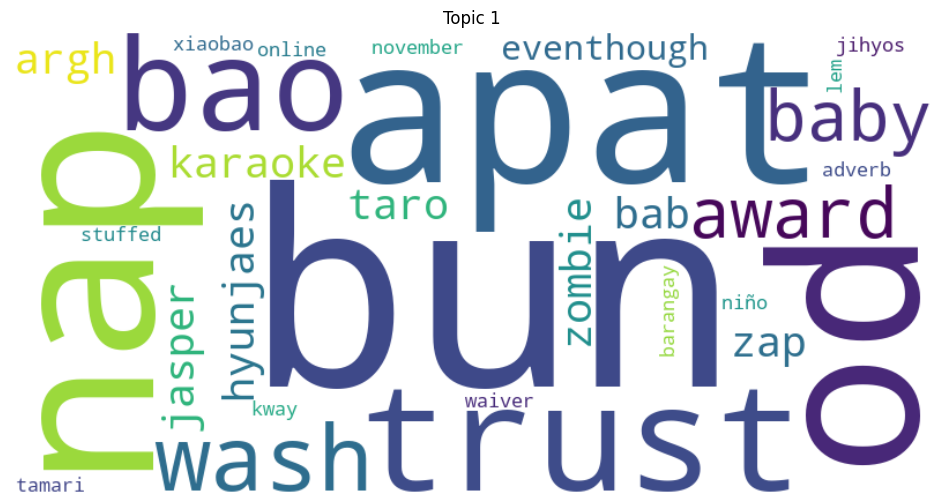

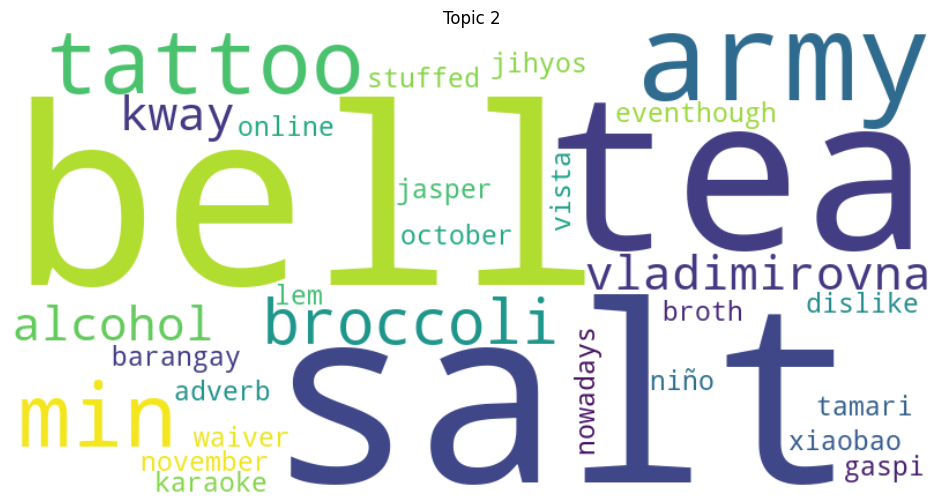

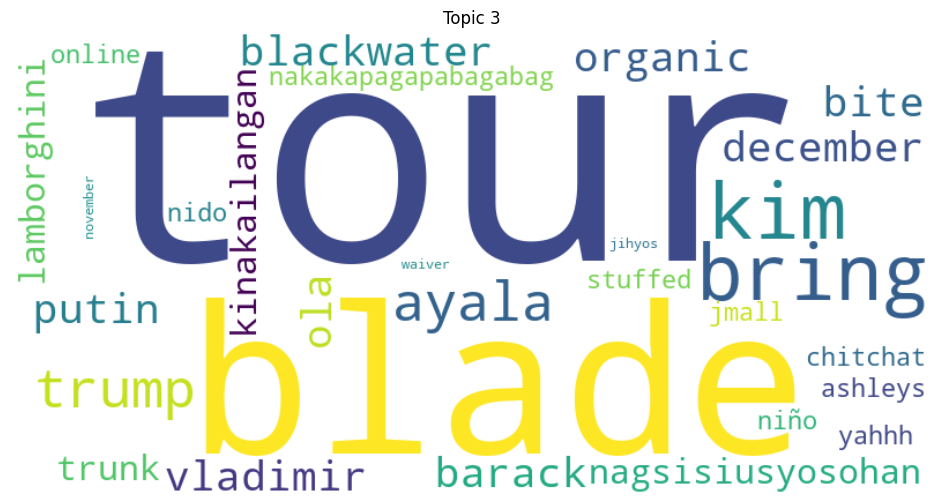

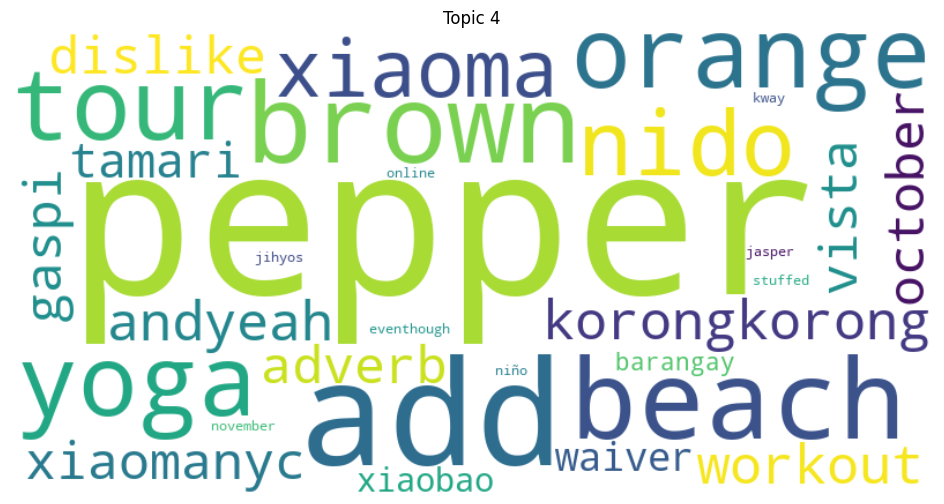

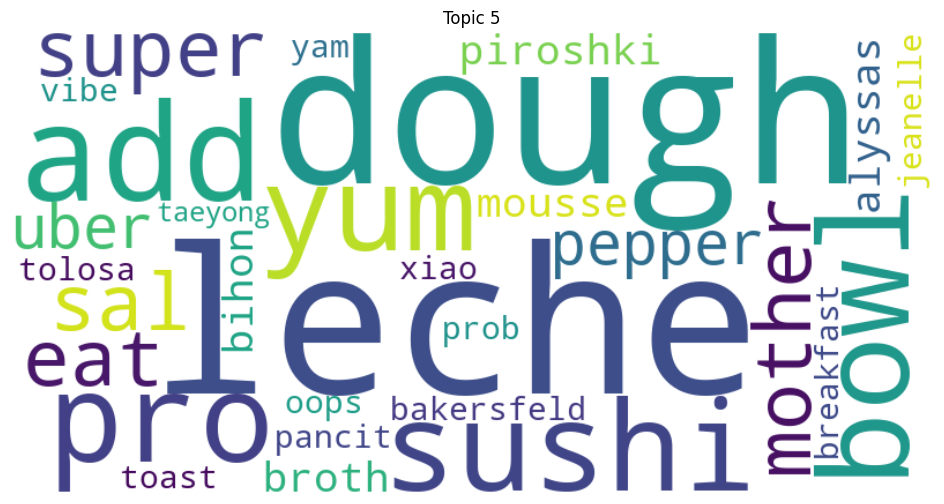

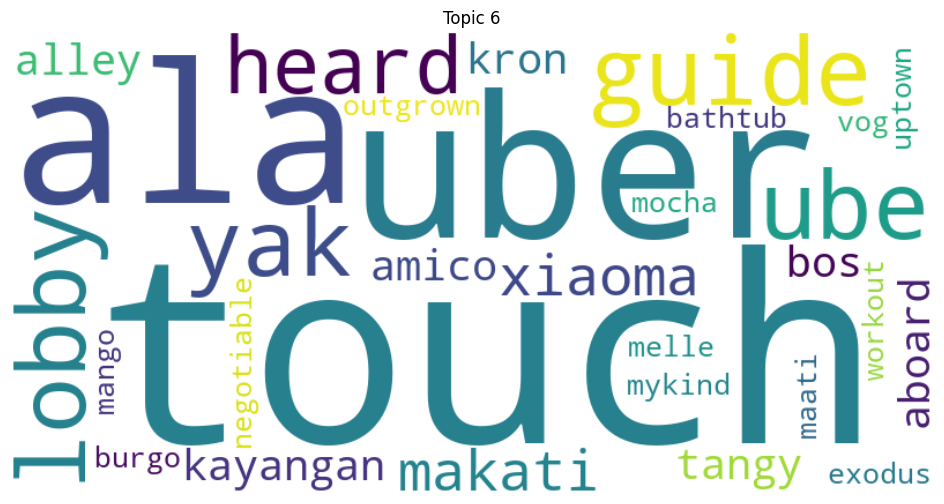

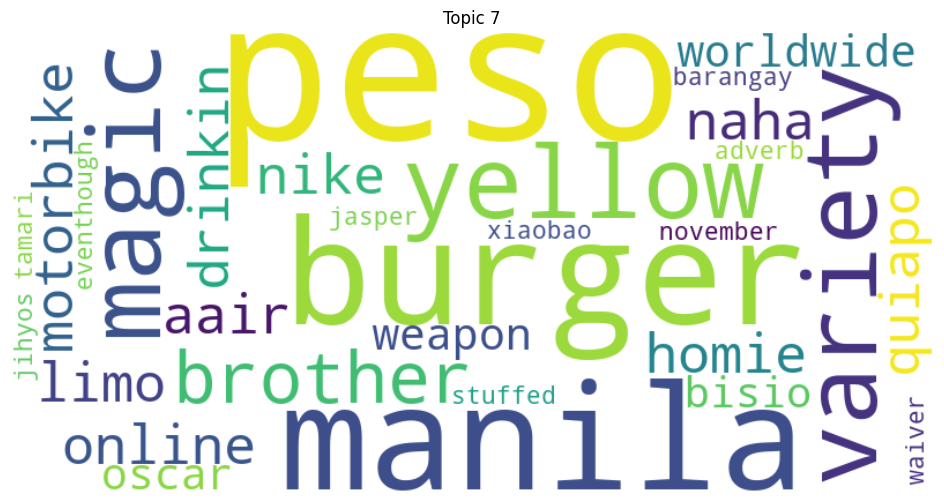

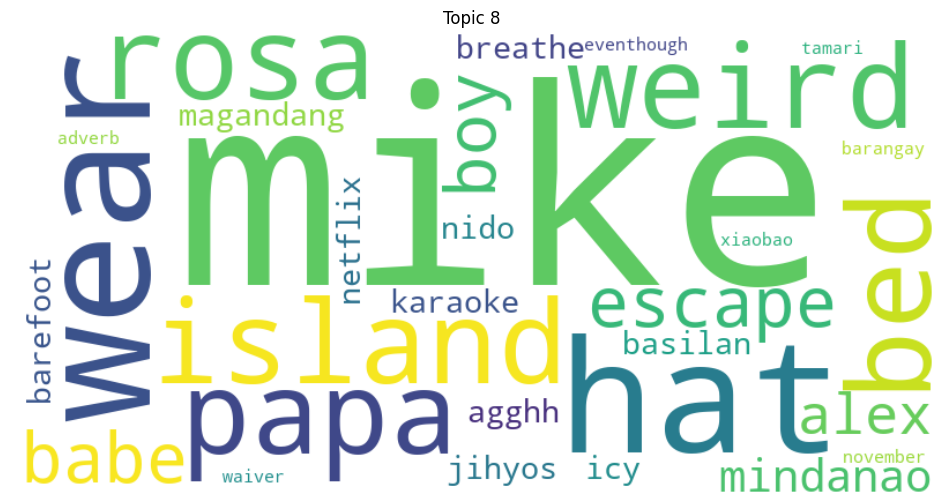

In [7]:
# 3RD RUN for Top2Bottom
# Preprocess all documents and combine them into a single corpus
combined_tokens = []

for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")
    
    preprocessed_doc = preprocess_text_with_tags(doc, video_id)
    
    if len(preprocessed_doc) > 0:
        combined_tokens.append(preprocessed_doc.split())  # Tokenize and append to the combined list

# Build dictionary and corpus from the combined data
if combined_tokens:
    dictionary = corpora.Dictionary(combined_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in combined_tokens]

    # Train a single LDA model on the combined corpus
    num_topics = 8  # Adjust the number of topics as needed
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=100, random_state=42)

    # Display topics
    print("\nGenerated Topics:")
    for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=30, formatted=True):
        print(f"Topic {idx + 1}: {topic}")
    
    # Function to generate word clouds for all topics
    def generate_wordcloud_for_all_topics(lda_model, num_words=30):
        topics = lda_model.show_topics(num_words=num_words, formatted=False)
        for t, words in topics:
            word_freq = {word[0]: word[1] for word in words}
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
            
            plt.figure(figsize=(20, 6))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Topic {t+1}")
            plt.show()

    # Generate and display word clouds for all topics
    generate_wordcloud_for_all_topics(lda_model)
else:
    print("No valid documents to process!")

Processing file: M9tx5tggT-k_captions.txt
Processing file: _MRKWqd3L3w_captions.txt
Processing file: VD5u8UqW_WI_captions.txt
Processing file: JyuDpnjCK_U_captions.txt
Processing file: 8KIMFLiprXo_captions.txt
Processing file: kv7cn2yuUCc_captions.txt
Processing file: atMwIFVnrnk_captions.txt
Processing file: q14xrmd8R6s_captions.txt
Processing file: H8qLpIt_Bqs_captions.txt
Processing file: AqT2DLoO7Gs_captions.txt
Processing file: YNjluhmwrOk_captions.txt
Processing file: fp19JCP2pCs_captions.txt
Processing file: PoDAa2Bt9bU_captions.txt
Processing file: 7OnrK3EmFa4_captions.txt
Processing file: BZA1TUcHa4k_captions.txt
Processing file: 7ObTYEQRcBs_captions.txt
Processing file: tSWAd-BjvO0_captions.txt
Processing file: DYrwSmgq9Xc_captions.txt
Processing file: RWS5Ru8QNig_captions.txt
Processing file: rQ0zqHlIs3A_captions.txt
Processing file: EUkFRzflw20_captions.txt
Processing file: N7ZUJU_8vU4_captions.txt
Processing file: 6Mhtr5yE-kc_captions.txt
Processing file: 00qBuhJeG-o_capti

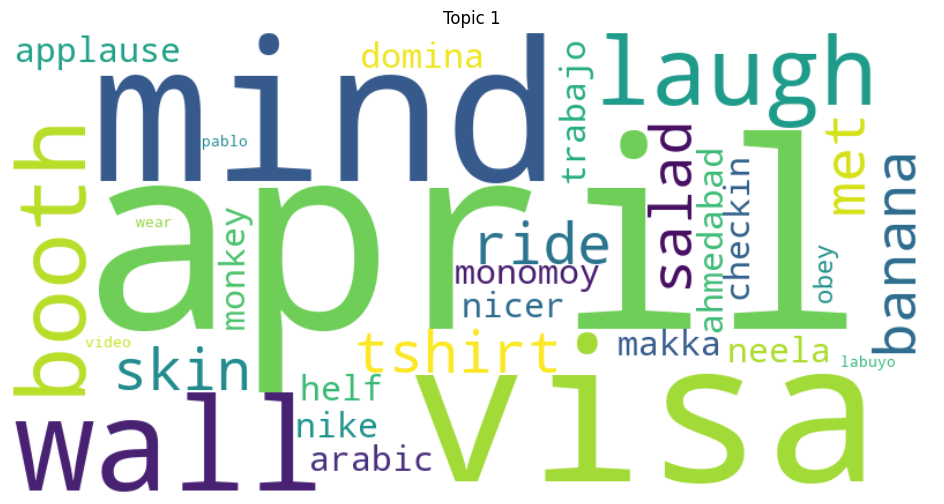

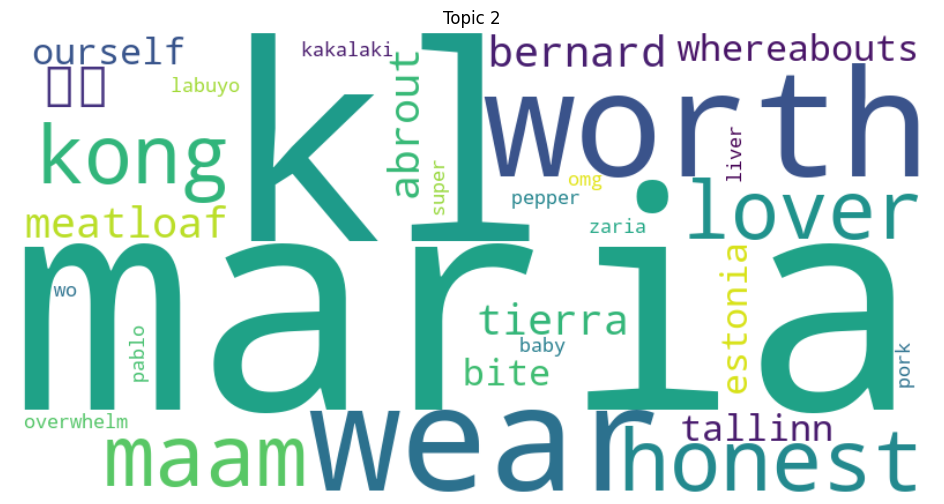

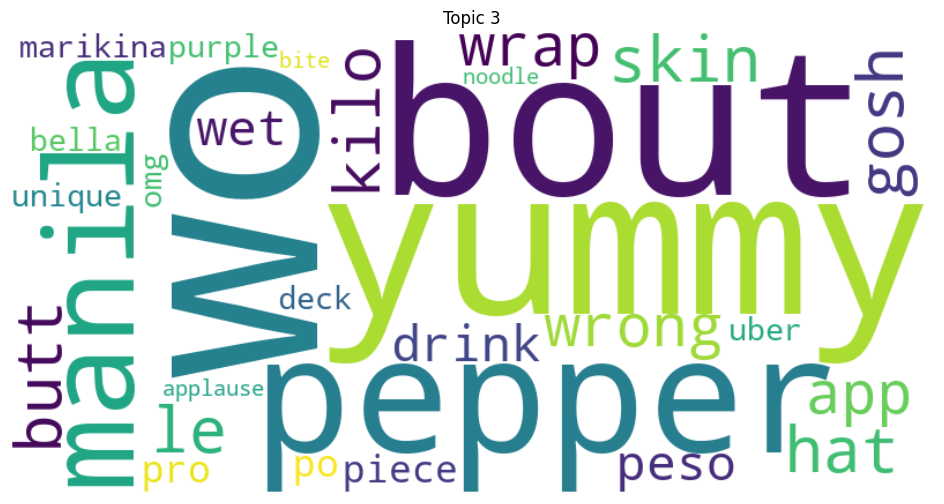

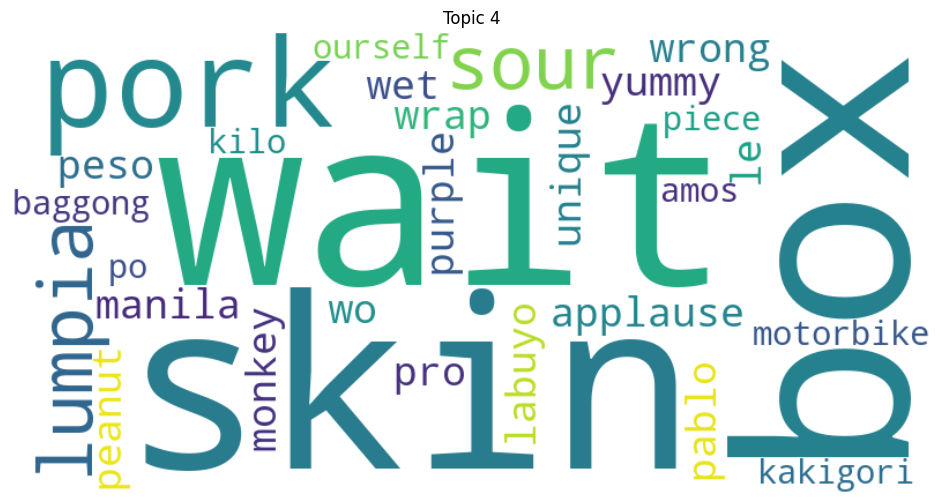

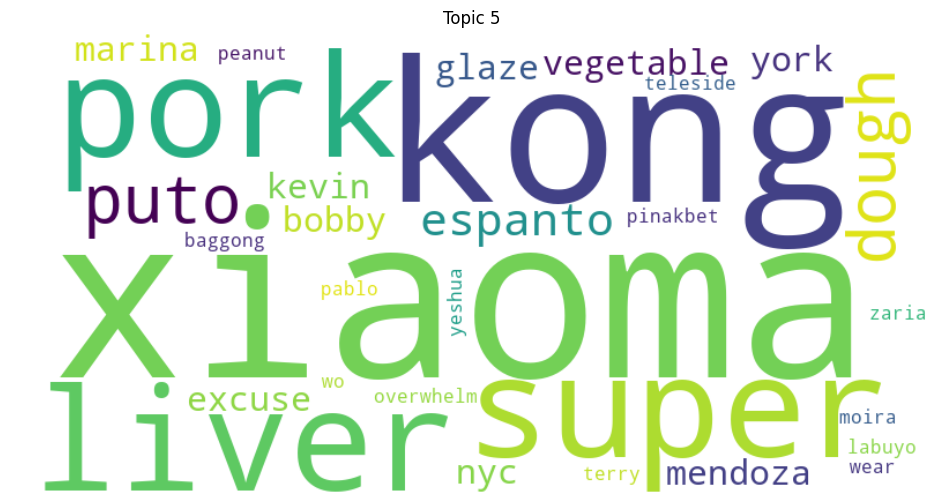

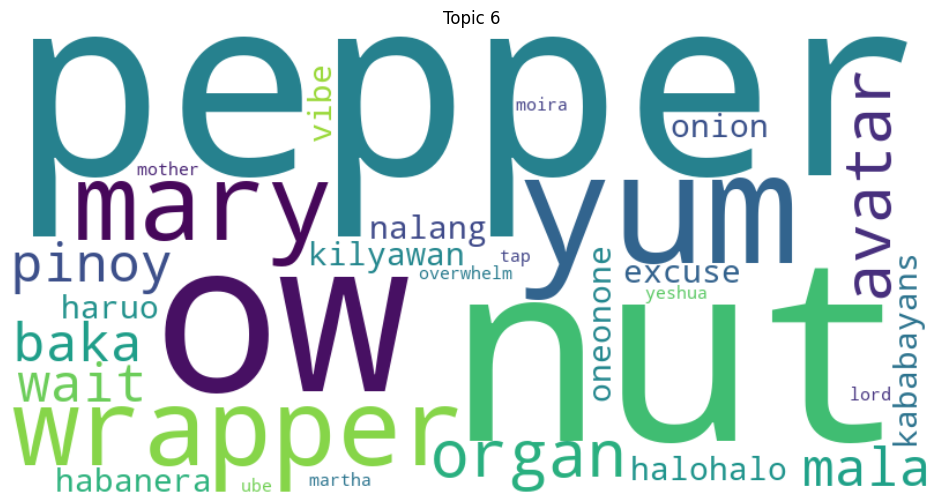

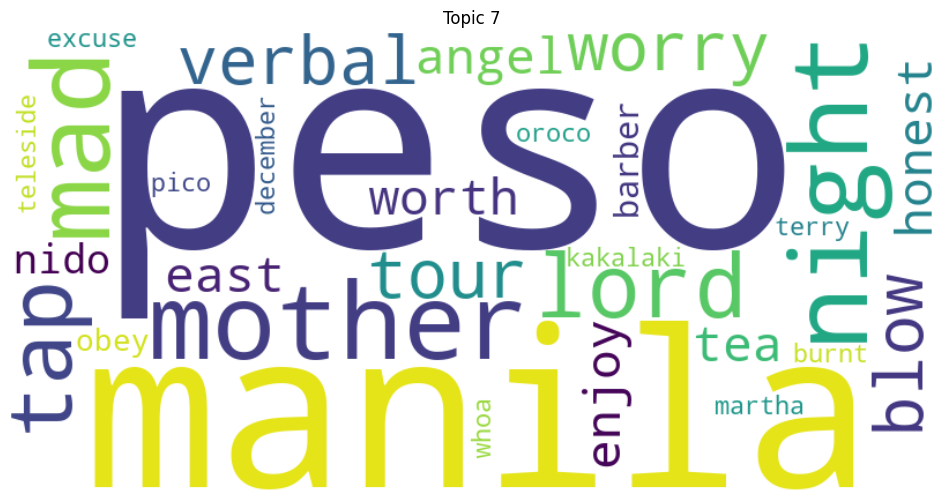

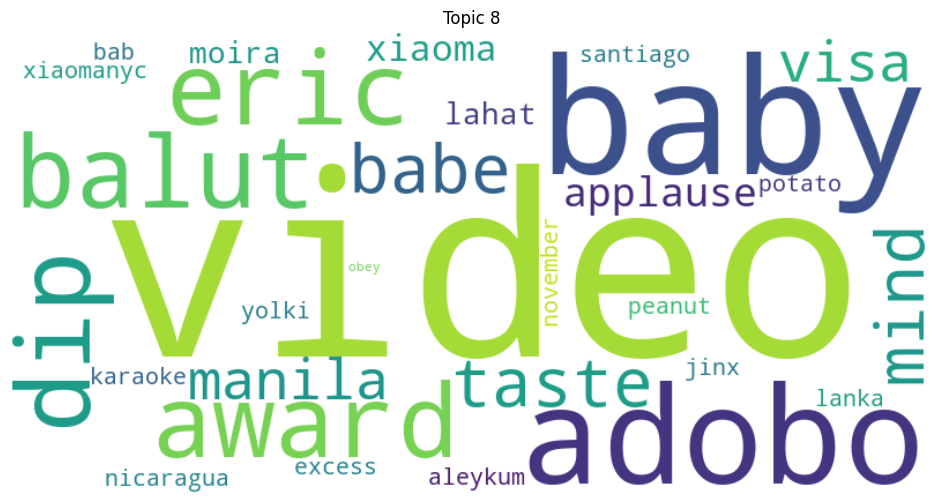

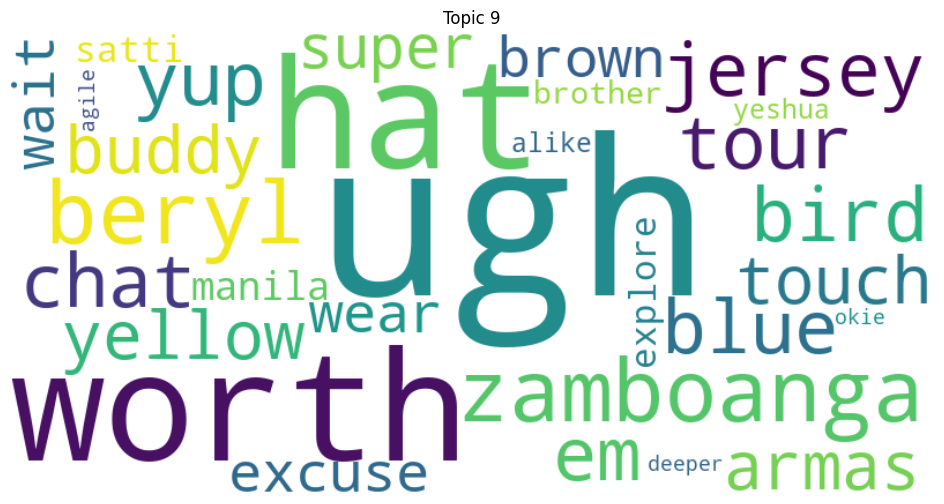

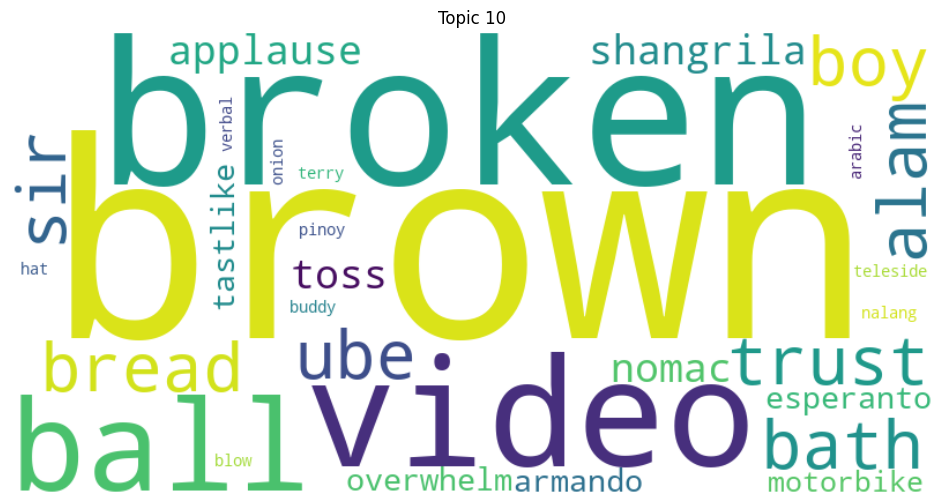

In [12]:
# 2ND RUN for Top2Bottom
# Preprocess all documents and combine them into a single corpus
combined_tokens = []

for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")
    
    preprocessed_doc = preprocess_text_with_tags(doc, video_id)
    
    if len(preprocessed_doc) > 0:
        combined_tokens.append(preprocessed_doc.split())  # Tokenize and append to the combined list

# Build dictionary and corpus from the combined data
if combined_tokens:
    dictionary = corpora.Dictionary(combined_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in combined_tokens]

    # Train a single LDA model on the combined corpus
    num_topics = 10  # Adjust the number of topics as needed
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=100, random_state=42)

    # Display topics
    print("\nGenerated Topics:")
    for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=30, formatted=True):
        print(f"Topic {idx + 1}: {topic}")
    
    # Function to generate word clouds for all topics
    def generate_wordcloud_for_all_topics(lda_model, num_words=30):
        topics = lda_model.show_topics(num_words=num_words, formatted=False)
        for t, words in topics:
            word_freq = {word[0]: word[1] for word in words}
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
            
            plt.figure(figsize=(20, 6))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Topic {t+1}")
            plt.show()

    # Generate and display word clouds for all topics
    generate_wordcloud_for_all_topics(lda_model)
else:
    print("No valid documents to process!")

Processing file: WHl8KIkWauY_captions.txt
Processing file: T7_k2imOvDw_captions.txt
Processing file: uHzkGJZsQVc_captions.txt
Processing file: lHdUFJCkAfQ_captions.txt
Processing file: 7i9At3fld3Q_captions.txt
Processing file: TVO3aqHMPYk_captions.txt
Processing file: zjJOawV31lo_captions.txt
Processing file: 0tA3LAVwkIo_captions.txt
Processing file: tYlsZMI9Ag8_captions.txt
Processing file: QeGqPTs8kvo_captions.txt
Processing file: nTTnNqw1awg_captions.txt
Processing file: Wst4kBA9jnQ_captions.txt
Processing file: MfftS_h6sNQ_captions.txt
Processing file: QXPDs1zcN_Y_captions.txt
Processing file: d_pI6qPlizQ_captions.txt
Processing file: MU061QXgKGk_captions.txt
Processing file: cApYOQViXbo_captions.txt
Processing file: lUy-hP3V-1o_captions.txt
Processing file: 57TY0y5zpe0_captions.txt
Processing file: N9ZT_Ot_1ao_captions.txt
Processing file: Dl8-_rRDfgE_captions.txt
Processing file: jyWS46pHtdA_captions.txt
Processing file: TA11qP7TuBg_captions.txt
Processing file: LfPx5Ygzr9A_capti

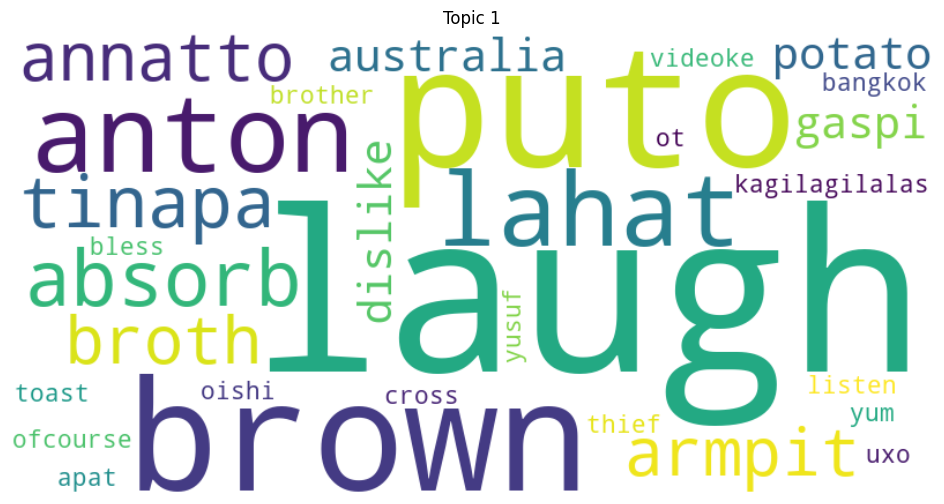

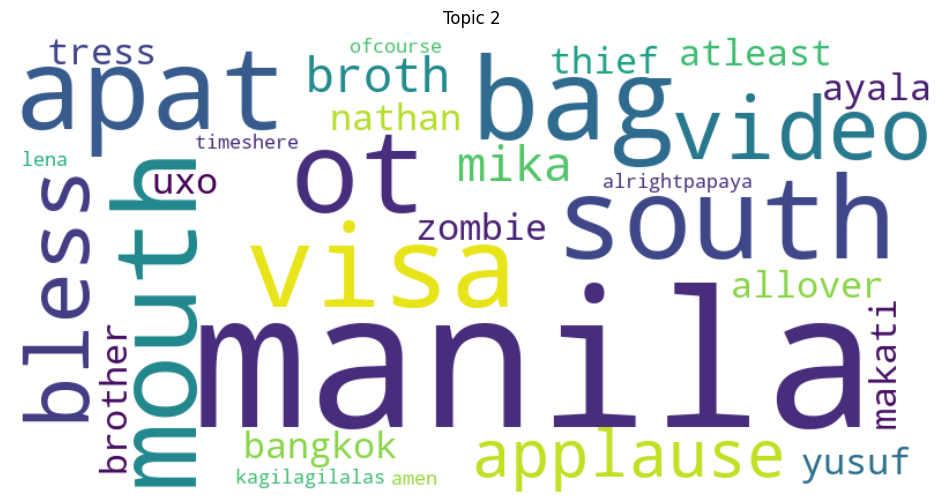

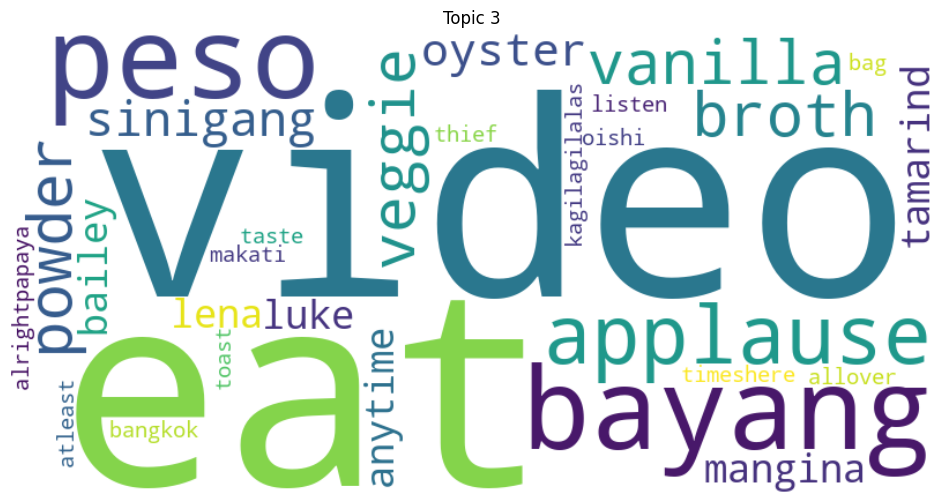

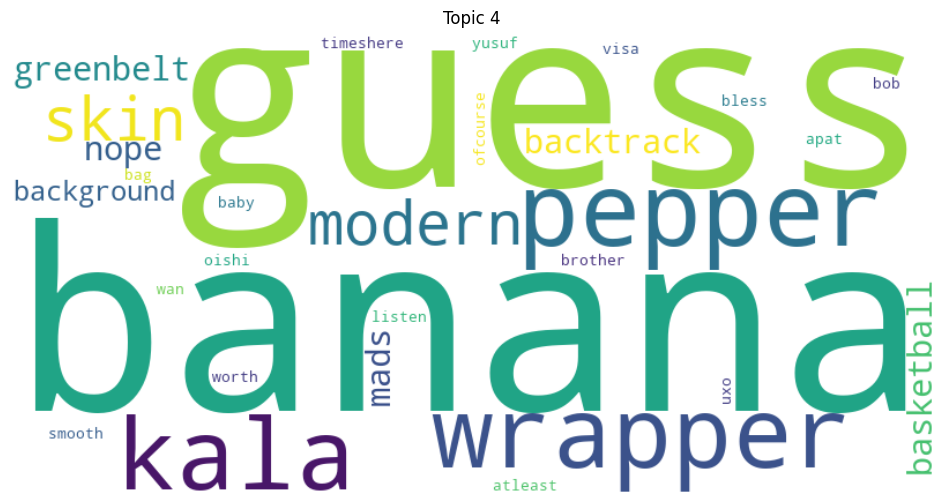

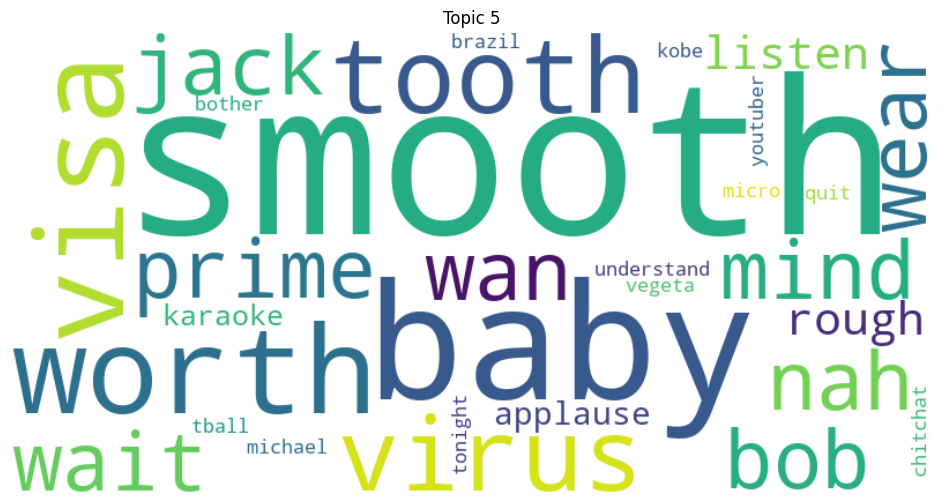

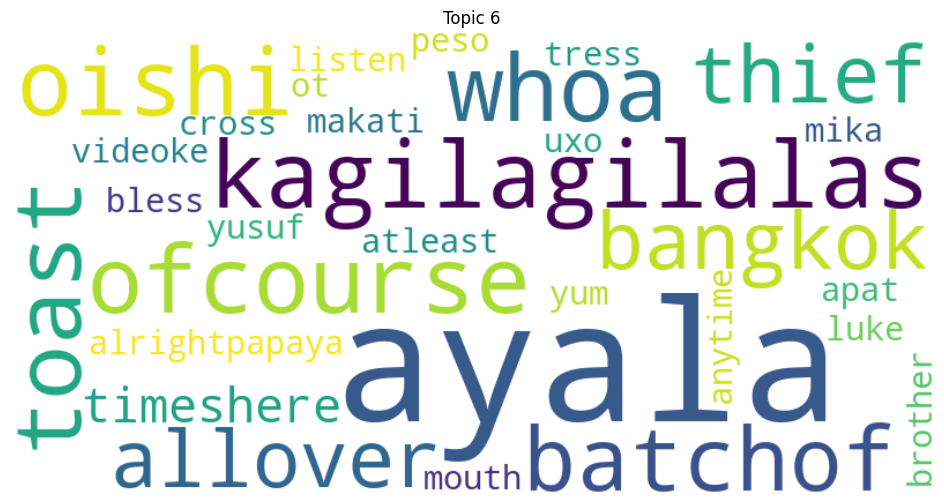

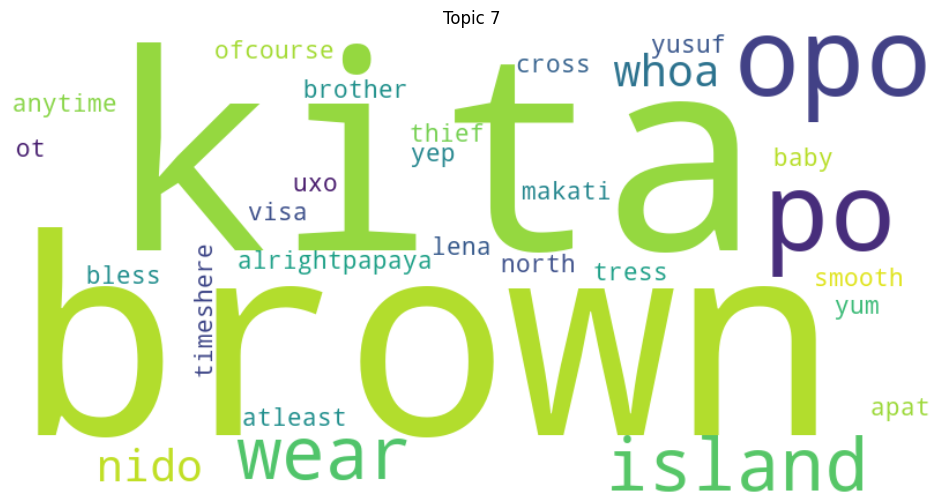

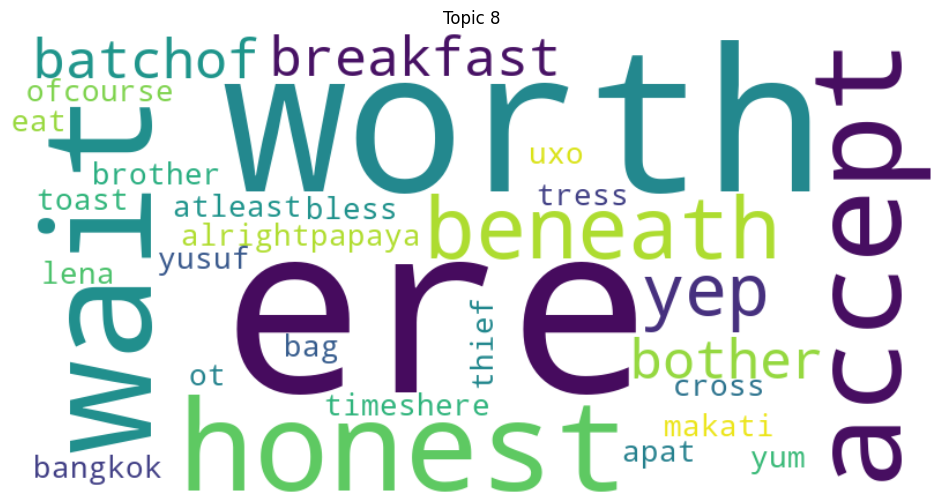

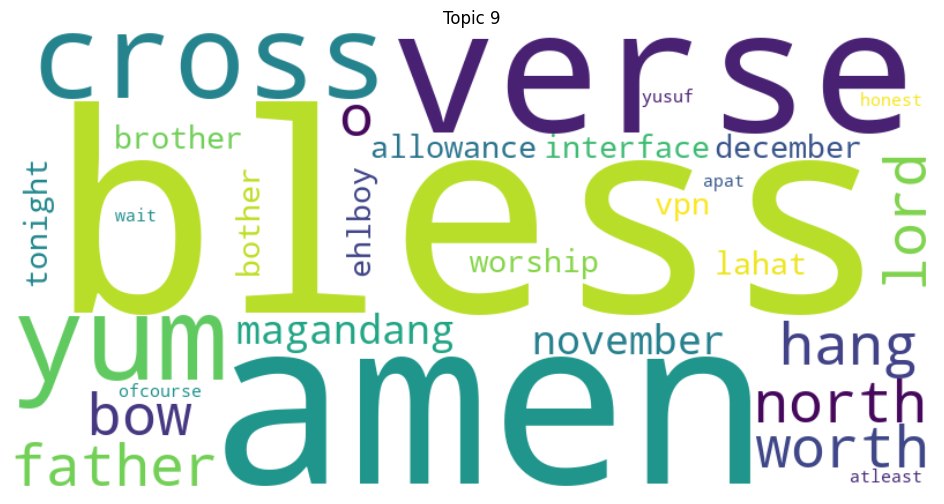

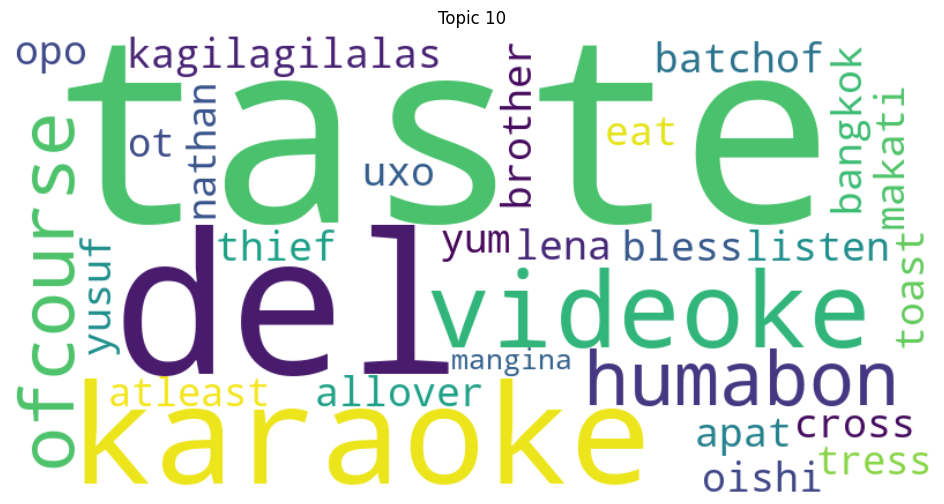

In [10]:
# 1ST RUN for Top2Bottom
# Preprocess all documents and combine them into a single corpus
combined_tokens = []

for i, doc in enumerate(documents):
    video_id = file_names[i].split('_captions')[0]
    print(f"Processing file: {file_names[i]}")
    
    preprocessed_doc = preprocess_text_with_tags(doc, video_id)
    
    if len(preprocessed_doc) > 0:
        combined_tokens.append(preprocessed_doc.split())  # Tokenize and append to the combined list

# Build dictionary and corpus from the combined data
if combined_tokens:
    dictionary = corpora.Dictionary(combined_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in combined_tokens]

    # Train a single LDA model on the combined corpus
    num_topics = 10  # Adjust the number of topics as needed
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=100, random_state=42)

    # Display topics
    print("\nGenerated Topics:")
    for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=30, formatted=True):
        print(f"Topic {idx + 1}: {topic}")
    
    # Function to generate word clouds for all topics
    def generate_wordcloud_for_all_topics(lda_model, num_words=30):
        topics = lda_model.show_topics(num_words=num_words, formatted=False)
        for t, words in topics:
            word_freq = {word[0]: word[1] for word in words}
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
            
            plt.figure(figsize=(20, 6))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"Topic {t+1}")
            plt.show()

    # Generate and display word clouds for all topics
    generate_wordcloud_for_all_topics(lda_model)
else:
    print("No valid documents to process!")